# **ANDROID MALWARE DETECTION USING NEURAL NETWORKS**
### **Jina Akusara-Universitas Gadjah Mada**

* **1. Introduction**
    * 1.1 Import dependecies
* **2. Data preparation**
    * 2.1 Load data, make training and validation set
    * 2.2 First look of dataset
* **3. Neural Networks**
    * 3.1 Define the neural network architecture
    * 3.2 Training process
* **4. Evaluate the model**
    * 4.1 Training procces visualization
    * 4.2 Confusion matrix
* **5. Prediction on New APK**
    * 5.1 Predicting Process
    * 5.2 Save the Model

# 1. Introduction

> Data *Benign* dan *Malignant* diperoleh dari salah satu laman University of New Brunswick dengan link: https://www.unb.ca/cic/datasets/andmal2017.html
Dataset tersebut terdiri dari 5 kelas, yaitu: Benign, Adware, Ransomeware, Scareware, SMSmalware.

> Melalui dataset ini kami menggunakan metode sampling, sehingga terdapat 2 kelas Benign dan Malignant. Malignant terdiri dari Adware, Ransomeware, Scareware, SMSmalware yang digabungkan sehingga diperoleh kelas Malignant. Masing masing kelas terdapat 140 data dan total seluruh data yang kami gunakan adalah 280.

> Melalui dataset apk tersebut kami proses menjadi *binary visualization* melalui laman binviz.io

> Produk AI ini terbuat dari 50 layer Residual Neural Network untuk *binary visualization* dari sebuah malware. Kami memilih untuk membuat produk ini dengan keras API. Pertama-tama, kita akan mempersiapkan data (*binary visualization images*) lalu kami akan berfokus pada Neural Networks *modeling* dan *evaluation*.

## 1.1 Importing dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# General Dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import datetime
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import cv2

# Neural Networks Dependecies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet, MobileNetV2, Xception

In [3]:
# Parameters
BATCH_SIZE = 64
N_CLASS = 2
IMG_SIZE = 512
VAL_SPLIT = 0.4
IN_CHANNELS = 3
RANDOM_SEED = 42
LEARNING_RATE = 0.001
EPOCHS = 20
CLASS_NAMES = ["Benign", "Malignant"]

# 2. Data Preparation
## 2.1 Load data, make train and validation set

In [4]:
# Load the Dataset
datasets = "/content/drive/MyDrive/TSDN_2023/Dataset_"

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    datasets,
    subset="training",
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    datasets,
    subset="validation",
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)

Found 280 files belonging to 2 classes.
Using 168 files for training.
Found 280 files belonging to 2 classes.
Using 112 files for validation.


## 2.2 First look of dataset

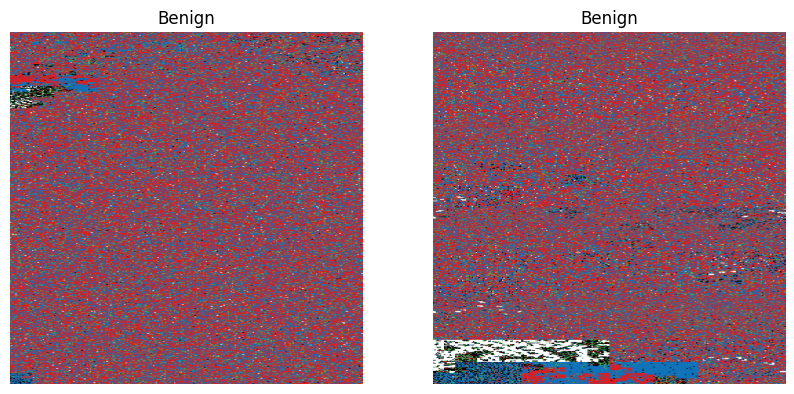

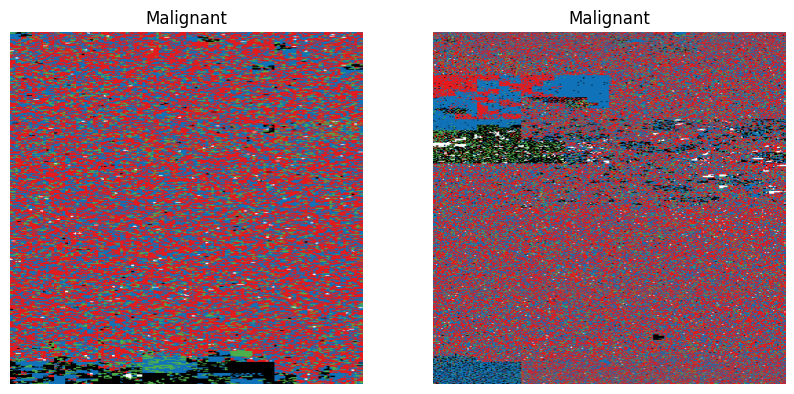

In [6]:
# Get class names from the dataset
class_names = train_dataset.class_names

# Create a function to plot images from a specific class
def plot_images_from_class(dataset, class_name, num_images=N_CLASS):
    plt.figure(figsize=(10, 10))
    class_index = class_names.index(class_name)

    images = []
    labels = []

    # Collect images and labels for the specified class
    for image_batch, label_batch in dataset:
        for i in range(len(label_batch)):
            label = np.argmax(label_batch[i])
            if label == class_index:
                images.append(image_batch[i])
                labels.append(class_name)
            if len(images) == num_images:
                break
        if len(images) == num_images:
            break

    # Plot the images
    for i in range(len(images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i])
        plt.axis("off")

# Visualize images from each class
for class_name in class_names:
    plot_images_from_class(train_dataset, class_name)

plt.show()

# 3. Neural Networks

### 3.1 Define the neural network architecture

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

class MyModel(Sequential):
    def __init__(self, pretrained_model, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.pretrained_model = pretrained_model
        self.add(pretrained_model)
        self.add(Flatten())
        self.add(Dense(512, activation='relu'))
        self.add(Dense(N_CLASS, activation='sigmoid'))

    def get_config(self):
        config = super(MyModel, self).get_config()
        config.update({
            'pretrained_model': self.pretrained_model
        })
        return config

pretrained_model= ResNet50(include_top=False,
                           input_shape=(IMG_SIZE,IMG_SIZE,IN_CHANNELS),
                           pooling='avg',
                           classes=N_CLASS,
                           weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model = MyModel(pretrained_model)

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
resnet_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [9]:
resnet_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

## 3.2 Training Process

In [10]:
resnet_history = resnet_model.fit(train_dataset,
                                  validation_data=val_dataset,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS)

Epoch 1/20
3/3 [==============================] - 61s 18s/step - loss: 1.8028 - accuracy: 0.5119 - val_loss: 0.6638 - val_accuracy: 0.6696
Epoch 2/20
3/3 [==============================] - 10s 3s/step - loss: 1.1049 - accuracy: 0.5595 - val_loss: 1.3223 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 9s 3s/step - loss: 0.9407 - accuracy: 0.6190 - val_loss: 0.7569 - val_accuracy: 0.6964
Epoch 4/20
3/3 [==============================] - 10s 3s/step - loss: 0.8012 - accuracy: 0.7321 - val_loss: 0.6828 - val_accuracy: 0.7589
Epoch 5/20
3/3 [==============================] - 9s 3s/step - loss: 0.5595 - accuracy: 0.7679 - val_loss: 0.7020 - val_accuracy: 0.7411
Epoch 6/20
3/3 [==============================] - 11s 3s/step - loss: 0.6298 - accuracy: 0.7679 - val_loss: 0.5717 - val_accuracy: 0.7500
Epoch 7/20
3/3 [==============================] - 11s 3s/step - loss: 0.4902 - accuracy: 0.8036 - val_loss: 0.6299 - val_accuracy: 0.7946
Epoch 8/20
3/3 [===================

## 4. Evaluate the model

### 4.1 Training procces visualization

In [11]:
def plot_accuracy(history, model_name, ax):
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.axis(ymin=0.4, ymax=1)
    ax.grid()
    ax.set_title(f'{model_name} Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epochs')
    ax.legend(['train', 'validation'])

def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.grid()
    ax.set_title(f'{model_name} loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.legend(['train', 'validation'])

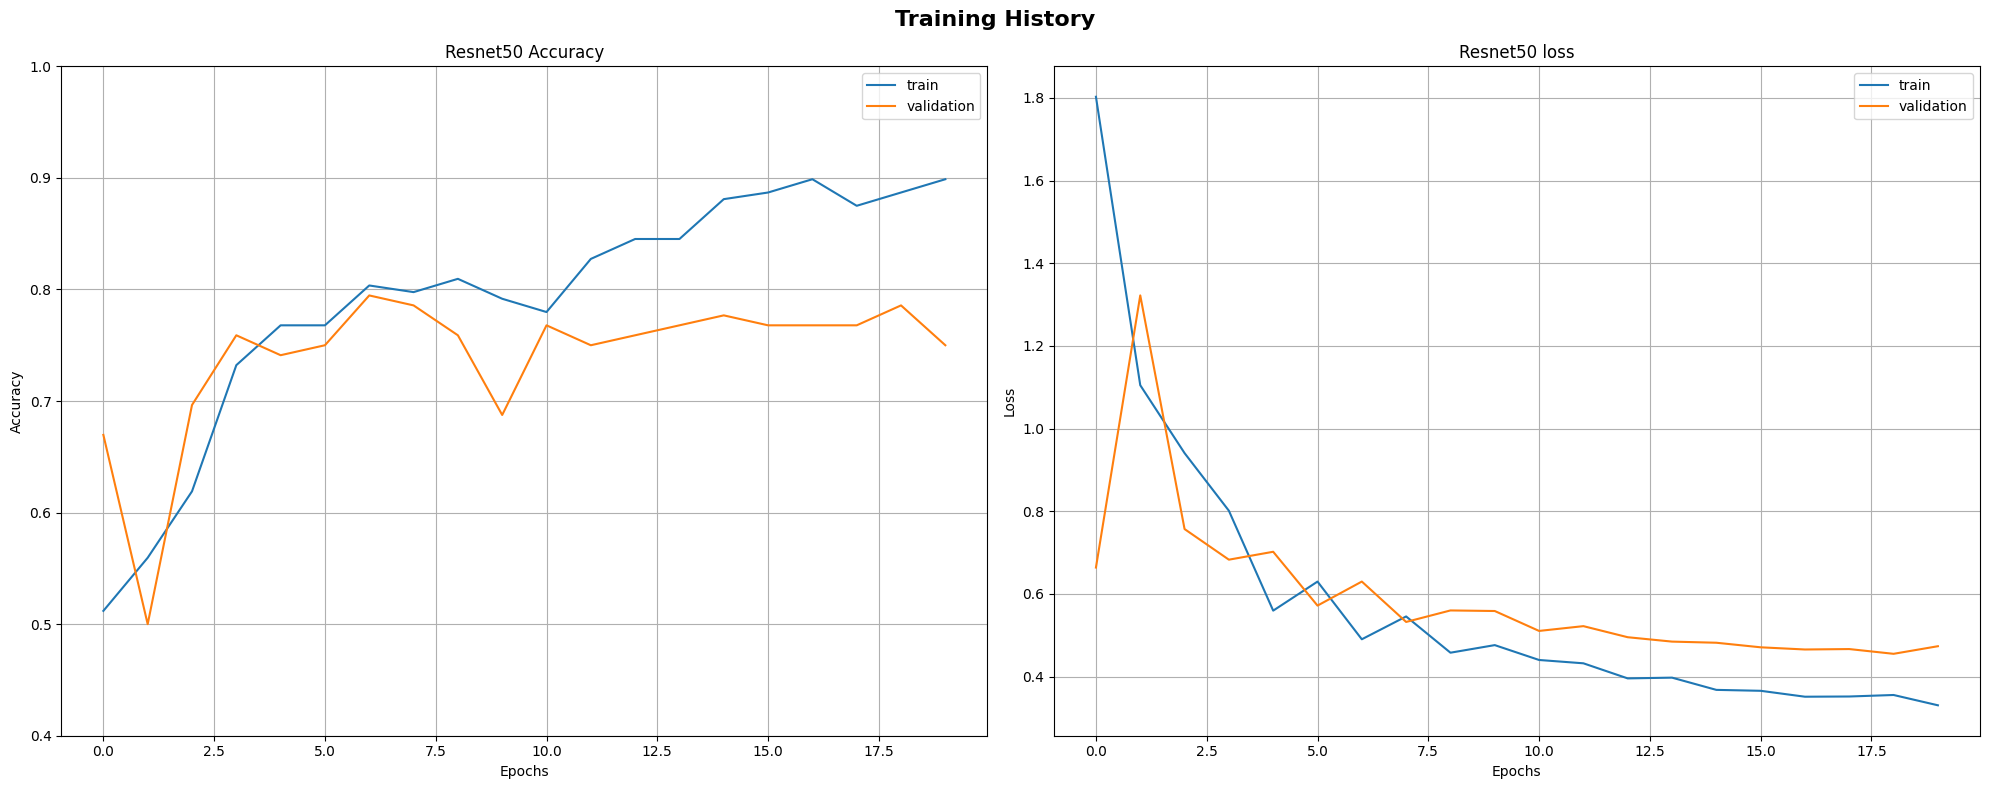

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot each accuracy plot on a separate subplot
plot_accuracy(resnet_history, "Resnet50", axs[0])
plot_loss(resnet_history, "Resnet50", axs[1])

fig.suptitle('Training History', fontsize=16, fontweight='bold')
# fig.suptitle('Comparison of all models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 Confusion Matrix

2/2 [==============================] - 7s 48ms/step
Confusion Matrix:
[[22 13]
 [ 3 26]]
Accuracy: 0.75
Precision: 0.7833333333333333
Recall: 0.75
F1 Score: 0.7475490196078431


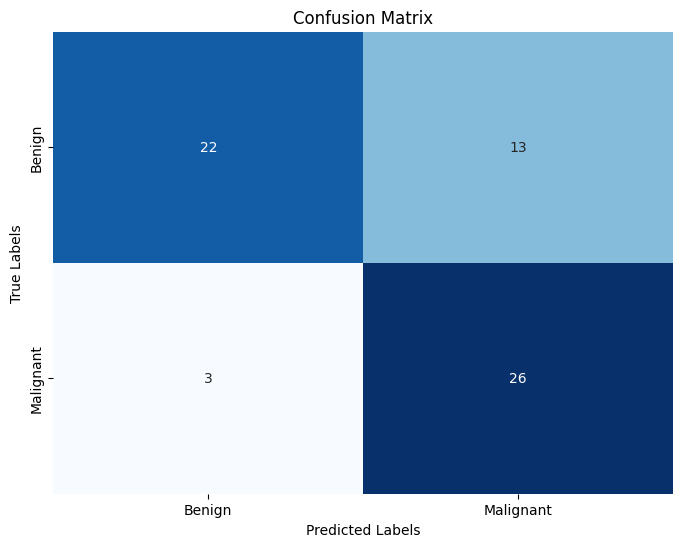

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Example of obtaining predictions and true labels (replace this with your actual code):
val_images, val_labels = next(iter(val_dataset))
predictions = resnet_model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax output to class labels

true_labels = np.argmax(val_labels, axis=1)  # Assuming val_labels are in one-hot encoded format

# Create the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
precision = metrics.precision_score(true_labels, predicted_labels, average='weighted')
recall = metrics.recall_score(true_labels, predicted_labels, average='weighted')
f1_score = metrics.f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

# Plot the confusion matrix using seaborn and matplotlib with class names
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## 5. Prediction on New APK

### 5.1 Predicting Process

In [50]:
def test_apk(path):
  image = cv2.imread(path)
  image_processing = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image_processing = np.expand_dims(image_processing, axis = 0)

  pred=resnet_model.predict(image_processing)
  print(f"Probability of Predictions: {pred}")

  output_class=CLASS_NAMES[np.argmax(pred)]
  print(f"The predicted class is {output_class}")

In [51]:
test_apk("/content/1d52a12dad15d8a6ea59467ec8ec4732.png")

1/1 [==============================] - 0s 37ms/step
Probability of Predictions: [[0.4468295 0.5802096]]
The predicted class is Malignant


In [52]:
test_apk("/content/google-chrome-119-0-6045-66.png")

1/1 [==============================] - 0s 39ms/step
Probability of Predictions: [[0.8554173  0.08262326]]
The predicted class is Benign


In [53]:
test_apk("/content/mobile-legends-21-8-20-8941.png")

1/1 [==============================] - 0s 35ms/step
Probability of Predictions: [[0.7818852 0.5087211]]
The predicted class is Benign


### 5.2 Save the Model

In [30]:
resnet_model.save("/content/Jina_Akusara.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
